# Capstone: Utilizing Tweets to Predict Future Trends in BTC
Whether you're bullish or bearish on Bitcoin you can agree on one thing - the commodity is volatile.  Prices can drop 10-20% within an hour and then be up 30% from the original price 4 hours later.  If there was a way to accurately predict the future trend of the commodity you could reap rewards many times over within a day.

If there was ever a perfect platform to utilize natural language processing to gauge sentiment on a topic you couldn't find a better platform than Twitter.  Twitter is a social media platform allowing users to "microblog" through the use of 280 characters of text or what the platform defines as a "tweet".  These tweets can be tracked by topic through the use of hashtags, and in that manner the topic of interest can be analyzed by viewing the tweets.

Through the use of some natural language processing and supervised learning what we've done here is created a model that can predict the future trend of BTC by analyzing historical twitter data and the crypto's volume.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import re
import scipy
import sys
import jsonpickle
import os
import matplotlib.pyplot as plt
import nltk
import warnings
%matplotlib inline

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn import neighbors
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

import tweepy
import csv
warnings.filterwarnings("ignore")

## Twitter Crawler
The first step was to gather the historical data from twitter.  Below is the code that was used to access the data via the platform's API.

What I came to find was that without a paid developer's account I would only be able to access the previous week's data, so I carried on with what data was available to me.

In [2]:
# Variables to hold access credentials for Twitter API
ACCESS_TOKEN = 'xxxx'
ACCESS_SECRET = 'xxxx'
CONSUMER_KEY = 'xxxx'
CONSUMER_SECRET = 'xxxx'

# Access API
def connect_to_twitter():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    api=tweepy.API(auth,wait_on_rate_limit=True)
    return api

# Create API object
api = connect_to_twitter()

In [3]:
# Check connection
pubilc_tweets = api.home_timeline()
for tweet in pubilc_tweets:
    print(tweet.text)

RT @WillieGeist: Tomorrow morning on #SundayTODAY, we revisit one of our favorite “Sunday Sitdowns” with Ryan Reynolds, whose company @Avia…
RT @TheDailyShow: Coronavirus seems to have put universal basic income back on the table, so who better for @ronnychieng to talk to than @A…
RT @McconeJohn: Mass #unemployment 

Overwhelmed welfare systems

Social unrest

People in lockdowns everywhere are starting to run out of…
RT @Alyssa_Milano: I just gave to Humanity Forward! https://t.co/d0AKWk9k4D
Our country is facing its worst crisis in modern history. Congress must pass, in the very near future, the boldest… https://t.co/36czMBzLbM
The growth rate of new US cases is declining a bit, even as test volume has started to increase again. It's pretty… https://t.co/cmaTB1rKQm
Join us soon for our virtual town hall at https://t.co/vreIiWfeoS. What questions do you have about the health and… https://t.co/0Hs2NuM75p
“People don’t eat in the long run. They eat every day.” - Harry Hopkins https://t.

In [4]:
# Access Twitter API using app authorization
auth = tweepy.AppAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)

aapi = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

if(not aapi):
    print("Can't Authenticate")
    sys.exit(-1)

In [10]:
searchQuery = '#BTC'  # this is what we're searching for
maxTweets = 999999999999 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits
fName = 'BTCtweets.txt' # We'll store the tweets in a text file.


# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, lang ='en', since='2020-01-01', count=tweetsPerQry)
                else:
                    new_tweets = api.search(q=searchQuery, lang ='en', since='2020-01-01', count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, lang ='en', since='2020-01-01', count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, lang ='en', since='2020-01-01', count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
                
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
            
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

Downloaded 81 tweets
Downloaded 170 tweets
Downloaded 236 tweets
Downloaded 303 tweets
Downloaded 376 tweets
Downloaded 457 tweets
Downloaded 526 tweets
Downloaded 602 tweets
Downloaded 672 tweets
Downloaded 743 tweets
Downloaded 824 tweets
Downloaded 891 tweets
Downloaded 949 tweets
Downloaded 1032 tweets
Downloaded 1093 tweets
Downloaded 1149 tweets
Downloaded 1224 tweets
Downloaded 1289 tweets
Downloaded 1371 tweets
Downloaded 1446 tweets
Downloaded 1517 tweets
Downloaded 1584 tweets
Downloaded 1672 tweets
Downloaded 1755 tweets
Downloaded 1830 tweets
Downloaded 1913 tweets
Downloaded 1980 tweets
Downloaded 2039 tweets
Downloaded 2104 tweets
Downloaded 2175 tweets
Downloaded 2252 tweets
Downloaded 2325 tweets
Downloaded 2408 tweets
Downloaded 2471 tweets
Downloaded 2540 tweets
Downloaded 2621 tweets
Downloaded 2697 tweets
Downloaded 2755 tweets
Downloaded 2823 tweets
Downloaded 2884 tweets
Downloaded 2952 tweets
Downloaded 3019 tweets
Downloaded 3093 tweets
Downloaded 3155 tweets
Do

Downloaded 25191 tweets
Downloaded 25266 tweets
Downloaded 25360 tweets
Downloaded 25428 tweets
Downloaded 25495 tweets
Downloaded 25566 tweets
Downloaded 25661 tweets
Downloaded 25729 tweets
Downloaded 25796 tweets
Downloaded 25863 tweets
Downloaded 25950 tweets
Downloaded 26014 tweets
Downloaded 26092 tweets
Downloaded 26163 tweets
Downloaded 26229 tweets
Downloaded 26316 tweets
Downloaded 26394 tweets
Downloaded 26465 tweets
Downloaded 26540 tweets
Downloaded 26626 tweets
Downloaded 26698 tweets
Downloaded 26772 tweets
Downloaded 26843 tweets
Downloaded 26896 tweets
Downloaded 26961 tweets
Downloaded 27033 tweets
Downloaded 27103 tweets
Downloaded 27180 tweets
Downloaded 27259 tweets
Downloaded 27327 tweets
Downloaded 27403 tweets
Downloaded 27481 tweets
Downloaded 27551 tweets
Downloaded 27608 tweets
Downloaded 27683 tweets
Downloaded 27747 tweets
Downloaded 27811 tweets
Downloaded 27876 tweets
Downloaded 27946 tweets
Downloaded 28026 tweets
Downloaded 28111 tweets
Downloaded 28181

Downloaded 53665 tweets
Downloaded 53734 tweets
Downloaded 53832 tweets
Downloaded 53912 tweets
Downloaded 53968 tweets
Downloaded 54046 tweets
Downloaded 54114 tweets
Downloaded 54209 tweets
Downloaded 54273 tweets
Downloaded 54355 tweets
Downloaded 54439 tweets
Downloaded 54519 tweets
Downloaded 54606 tweets
Downloaded 54678 tweets
Downloaded 54754 tweets
Downloaded 54815 tweets
Downloaded 54875 tweets
Downloaded 54970 tweets
Downloaded 55046 tweets
Downloaded 55125 tweets
Downloaded 55174 tweets
Downloaded 55235 tweets
Downloaded 55312 tweets
Downloaded 55377 tweets
Downloaded 55452 tweets
Downloaded 55544 tweets
Downloaded 55624 tweets
Downloaded 55719 tweets
Downloaded 55792 tweets
Downloaded 55872 tweets
Downloaded 55946 tweets
Downloaded 56013 tweets
Downloaded 56104 tweets
Downloaded 56202 tweets
Downloaded 56294 tweets
Downloaded 56376 tweets
Downloaded 56448 tweets
Downloaded 56538 tweets
Downloaded 56608 tweets
Downloaded 56695 tweets
Downloaded 56784 tweets
Downloaded 56868

Downloaded 80914 tweets
Downloaded 81014 tweets
Downloaded 81109 tweets
Downloaded 81200 tweets
Downloaded 81300 tweets
Downloaded 81395 tweets
Downloaded 81495 tweets
Downloaded 81595 tweets
Downloaded 81695 tweets
Downloaded 81795 tweets
Downloaded 81895 tweets
Downloaded 81995 tweets
Downloaded 82095 tweets
Downloaded 82172 tweets
Downloaded 82267 tweets
Downloaded 82367 tweets
Downloaded 82456 tweets
Downloaded 82551 tweets
Downloaded 82636 tweets
Downloaded 82732 tweets
Downloaded 82832 tweets
Downloaded 82932 tweets
Downloaded 83031 tweets
Downloaded 83101 tweets
Downloaded 83180 tweets
Downloaded 83249 tweets
Downloaded 83336 tweets
Downloaded 83416 tweets
Downloaded 83502 tweets
Downloaded 83584 tweets
Downloaded 83684 tweets
Downloaded 83781 tweets
Downloaded 83849 tweets
Downloaded 83929 tweets
Downloaded 84002 tweets
Downloaded 84081 tweets
Downloaded 84173 tweets
Downloaded 84241 tweets
Downloaded 84308 tweets
Downloaded 84386 tweets
Downloaded 84473 tweets
Downloaded 84562

## Data Exploration and Feature Engineering

In [2]:
# Read json file created from crawler
twdf = pd.read_json('BTCtweets.json', lines=True)

In [3]:
# View data columns
twdf.columns

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'favorite_count', 'favorited', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata',
       'place', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'text', 'truncated', 'user',
       'possibly_sensitive', 'extended_entities', 'quoted_status'],
      dtype='object')

In [4]:
# View data shape
twdf.shape

(100975, 30)

In [5]:
# View initial data types
twdf.dtypes

contributors                             float64
coordinates                               object
created_at                   datetime64[ns, UTC]
entities                                  object
favorite_count                             int64
favorited                                   bool
geo                                       object
id                                         int64
id_str                                     int64
in_reply_to_screen_name                   object
in_reply_to_status_id                    float64
in_reply_to_status_id_str                float64
in_reply_to_user_id                      float64
in_reply_to_user_id_str                  float64
is_quote_status                             bool
lang                                      object
metadata                                  object
place                                     object
quoted_status_id                         float64
quoted_status_id_str                     float64
retweet_count       

In [6]:
# Quick view of data
twdf.head()

,contributors,coordinates,created_at,entities,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,...,retweet_count,retweeted,retweeted_status,source,text,truncated,user,possibly_sensitive,extended_entities,quoted_status
0,NaN,None,2020-04-05 02:40:49+00:00,"{'hashtags': [{'indices': [44, 50], 'text': 'p...",0,False,None,1246628833404407808,1246628833404407808,None,...,250,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/android"" ...",RT @CrypCade: Hey Caders! Excited about the #p...,False,"{'contributors_enabled': False, 'created_at': ...",NaN,NaN,NaN
1,NaN,None,2020-04-05 02:40:48+00:00,"{'hashtags': [{'indices': [20, 28], 'text': 'C...",0,False,None,1246628828149157888,1246628828149157888,None,...,2,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/android"" ...",RT @CircuitSociety: #CIRCUIT #RACING LIVE STRE...,False,"{'contributors_enabled': False, 'created_at': ...",NaN,NaN,NaN
2,NaN,None,2020-04-05 02:40:42+00:00,"{'hashtags': [{'indices': [43, 52], 'text': 'd...",0,False,None,1246628801859276801,1246628801859276800,None,...,2,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/android"" ...",RT @ByteComics: Hey @blazzordDGB I did it! #di...,False,"{'contributors_enabled': False, 'created_at': ...",0.0,NaN,NaN
3,NaN,None,2020-04-05 02:40:35+00:00,"{'hashtags': [{'indices': [5, 9], 'text': 'BTC...",0,False,None,1246628774583717889,1246628774583717888,None,...,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",$btc #BTC | W | SQR OF 9\n@gocharting #gochart...,False,"{'contributors_enabled': False, 'created_at': ...",0.0,{'media': [{'display_url': 'pic.twitter.com/1j...,NaN
4,NaN,None,2020-04-05 02:40:03+00:00,"{'hashtags': [{'indices': [41, 56], 'text': 'C...",0,False,None,1246628637614301184,1246628637614301184,None,...,39,False,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/android"" ...",RT @CryptoNym0us: Which is your favorite #Cryp...,False,"{'contributors_enabled': False, 'created_at': ...",NaN,NaN,NaN


Taking a look at the data the only columns we want from this dataframe are the text of the tweet, the date created, the favorite count, and the retweet count.

In [7]:
# Drop columns we're not interested in
twdf = twdf.drop(columns=['contributors', 'coordinates', 'entities', 'favorited', 'geo', 'id', 'id_str',
                         'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
                         'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang',
                         'metadata', 'place', 'quoted_status_id', 'quoted_status_id_str', 'retweeted',
                         'retweeted_status', 'source', 'truncated', 'user', 'possibly_sensitive',
                         'extended_entities', 'quoted_status'])

In [10]:
# Verify text is in string format
twdf['text'] = twdf['text'].astype(str)

With the twitter data available at hand the next step was to download historical BTC prices and volume.  This was done with data from a company called coinbase, which allowed their hourly prices and volumes to be downloaded in CSV format.

In [12]:
# Read downloaded CSV
btcprice = pd.read_csv('BTCUSD.csv')

In [13]:
# View columns
btcprice.columns

Index(['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume BTC',
       'Volume USD'],
      dtype='object')

In [14]:
# View data types
btcprice.dtypes

Date           object
Symbol         object
Open          float64
High          float64
Low           float64
Close         float64
Volume BTC    float64
Volume USD    float64
dtype: object

In [15]:
# Convert date to date-time object
btcprice['Date'] = pd.to_datetime(btcprice['Date'], format='%Y-%m-%d %I-%p')

In [16]:
# Create columns to merge on
twdf['month'] = twdf['created_at'].dt.month
twdf['day'] = twdf['created_at'].dt.day
twdf['hour'] = twdf['created_at'].dt.hour

btcprice['month'] = btcprice['Date'].dt.month
btcprice['day'] = btcprice['Date'].dt.day
btcprice['hour'] = btcprice['Date'].dt.hour

btcprice['year'] = btcprice['Date'].dt.year

In [17]:
# Cleaning twitter text

# Lowercase
twdf['text'] = twdf['text'].str.lower()

# Remove special characters and numbers
twdf['text'] = twdf['text'].apply(lambda x : re.sub("[^a-z\s]","",x) )

# Remove stop words
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
twdf['text'] = twdf['text'].apply(lambda x : " ".join(word for word in x.split() if word not in stopwords ))

In [18]:
# Quick view of cleaned tweets
twdf['text'].head()

0    rt crypcade hey caders excited poker tournamen...
1    rt circuitsociety circuit racing live stream b...
2    rt bytecomics hey blazzorddgb digibyte comics ...
3    btc btc w sqr gocharting gocharting marketgeom...
4    rt cryptonymus favorite cryptocurrency top h b...
Name: text, dtype: object

In [19]:
# Vectorize text of tweets
from collections import defaultdict

def vectorize(doc):
    features = defaultdict(doc)
    for token in tokenize(doc):
        features[token] += 1
    return features

twdf['vec'] = map(vectorize, twdf['text'])

Here we're using term frequency-inverse document frequency to get a list of terms that we're going to searching the tweets for.  We're going to look at the history of tweets available to us as a collection and view the number of times a word appears in the collection offset by the number of tweets in the collection that contain the word.

Because in this case the majority of stop words have been removed I've minimized the tolerances to allow more terms to come through.

In [20]:
# Analyzing the using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=.0025)
tvec_weights = tvec.fit_transform(twdf['text'])
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(30)

,term,weight
77,btc,0.086637
489,rt,0.069462
51,bitcoin,0.054825
225,follow,0.034803
254,giveaway,0.032111
16,amp,0.030918
134,crypto,0.028649
479,retweet,0.027148
341,like,0.023711
7,airdrop,0.022909


In [21]:
# Using list of words, count occurrence in tweet and add as column to dataframe
feats = weights_df.sort_values(by='weight', ascending=False).head(30).term.tolist()

for x in feats:
    twdf[x] = twdf['text'].str.contains(x)
    twdf[x] = twdf[x].astype(int)

In [22]:
# Aggregate by hour
twdfg = twdf.groupby(['month', 'day', 'hour'], as_index=False).agg('sum')

In [23]:
# Viewing single month day and hour of BTC price
btcprice.loc[(btcprice.month==3) & (btcprice.day==28) & (btcprice.hour==14)]

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,month,day,hour,year
93,2020-03-28 14:00:00,BTCUSD,6239.38,6266.06,6232.14,6254.10,382.76,2392439.20,3,28,14,2020
8877,2019-03-28 14:00:00,BTCUSD,4012.57,4017.43,4008.83,4017.43,275.85,1106465.85,3,28,14,2019
17637,2018-03-28 14:00:00,BTCUSD,8019.99,8021.00,7875.00,7895.56,865.42,6860478.65,3,28,14,2018


In [24]:
# Because the twitter data could only be scraped from one week back
# we will not need and prices before the year 2020
btcp = btcprice.loc[btcprice['year']==2020]

In [25]:
# Merge price data onto twitter data
data = twdfg.merge(btcp.drop(columns='Symbol'), how='left', on=['month', 'day', 'hour'])

In [26]:
# Remove non-overlapping data and unecessary columns
df = data.dropna()
df = df.drop(columns='year')

In [27]:
# Quick view of final dataframe
df.head()

,month,day,hour,favorite_count,retweet_count,btc,rt,bitcoin,follow,giveaway,...,friends,address,xrp,Date,Open,High,Low,Close,Volume BTC,Volume USD
0,3,28,14,273,153022,97,193,57,67,59,...,46,18,12,2020-03-28 14:00:00,6239.38,6266.06,6232.14,6254.10,382.76,2392439.20
1,3,28,15,768,310510,199,409,92,159,105,...,107,14,22,2020-03-28 15:00:00,6254.10,6284.00,6225.50,6228.50,392.33,2452539.06
2,3,28,16,1160,378498,231,458,75,79,24,...,24,15,19,2020-03-28 16:00:00,6228.50,6250.04,6208.32,6243.92,529.11,3297603.24
3,3,28,17,468,245731,165,346,99,43,3,...,12,7,26,2020-03-28 17:00:00,6243.92,6249.00,6030.00,6040.57,1482.16,9086116.63
4,3,28,18,1858,190797,280,426,170,125,76,...,28,7,28,2020-03-28 18:00:00,6040.57,6264.81,6031.74,6177.04,1520.57,9407133.32


In [29]:
# Shape of final data frame
df.shape

(94, 42)

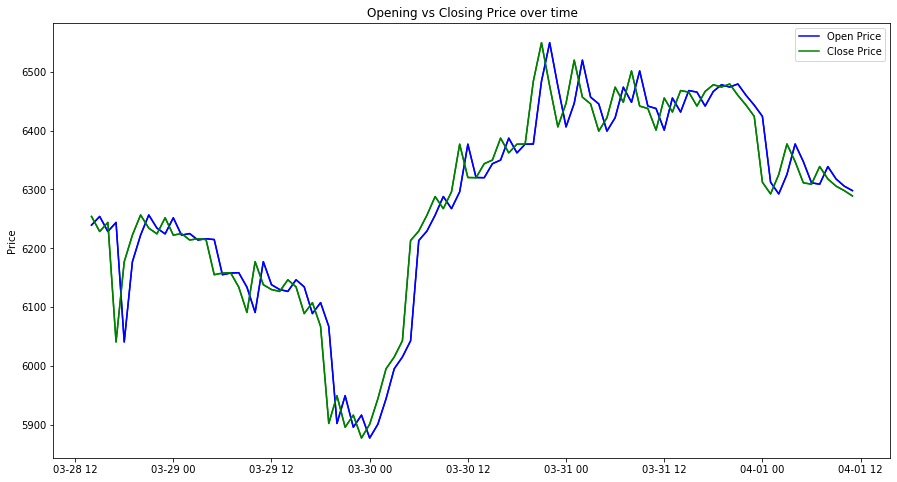

In [31]:
#Plot data
plt.figure(figsize=(15, 8))

plt.plot(df['Date'], df['Open'], color='blue')
plt.plot(df['Date'], df['Close'], color='green')
plt.ylabel('Price')
plt.title('Opening vs Closing Price over time')
line1, = plt.plot(df['Date'], df['Open'], color='blue')
line2, = plt.plot(df['Date'], df['Close'], color='green')
plt.legend(handles = [line1, line2], 
           labels  = ['Open Price', 'Close Price'])

plt.show()

The next step is to define what we're calling our trend which is also going to be our target variable.  What I'm doing here is bringing the next hours closing price to the previous row's data.  If the next hour's closing price is greater than the current hour's opening price then we are in an upward trend, if it's less than the current hour's open then we are in a downward trend.

In [32]:
# Take next hour's close to current hour's data
df['next_hour_close'] = df['Close'].shift(-1)

In [33]:
# Define trend
df['trend'] = df['next_hour_close'] > df['Open']
df['trend'] = df['trend'].astype(int)

In [34]:
# Quick view of data
df.head()

,month,day,hour,favorite_count,retweet_count,btc,rt,bitcoin,follow,giveaway,...,xrp,Date,Open,High,Low,Close,Volume BTC,Volume USD,next_hour_close,trend
0,3,28,14,273,153022,97,193,57,67,59,...,12,2020-03-28 14:00:00,6239.38,6266.06,6232.14,6254.10,382.76,2392439.20,6228.50,0
1,3,28,15,768,310510,199,409,92,159,105,...,22,2020-03-28 15:00:00,6254.10,6284.00,6225.50,6228.50,392.33,2452539.06,6243.92,0
2,3,28,16,1160,378498,231,458,75,79,24,...,19,2020-03-28 16:00:00,6228.50,6250.04,6208.32,6243.92,529.11,3297603.24,6040.57,0
3,3,28,17,468,245731,165,346,99,43,3,...,26,2020-03-28 17:00:00,6243.92,6249.00,6030.00,6040.57,1482.16,9086116.63,6177.04,0
4,3,28,18,1858,190797,280,426,170,125,76,...,28,2020-03-28 18:00:00,6040.57,6264.81,6031.74,6177.04,1520.57,9407133.32,6222.34,1


In [35]:
# View trend counts
df.trend.value_counts()

1    47
0    47
Name: trend, dtype: int64

What we see here is that the trend counts are evenly balanced, we have just as many upward trends as downward trends.

In [36]:
# Overview of data
df.describe()

,month,day,hour,favorite_count,retweet_count,btc,rt,bitcoin,follow,giveaway,...,address,xrp,Open,High,Low,Close,Volume BTC,Volume USD,next_hour_close,trend
count,94.00000,94.000000,94.000000,94.000000,9.400000e+01,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,9.400000e+01,93.000000,94.000000
mean,3.12766,26.085106,11.478723,792.765957,3.910278e+05,269.308511,434.712766,144.127660,115.276596,114.819149,...,49.521277,19.989362,6274.632553,6313.650319,6239.119574,6275.160851,676.576702,4.238546e+06,6275.387312,0.500000
std,0.33550,9.693873,7.031005,695.454789,4.325014e+05,105.614335,176.395244,60.696182,65.438702,75.544043,...,95.892382,6.367753,166.911497,166.784684,167.651821,166.877305,446.409965,2.788283e+06,167.767273,0.502681
min,3.00000,1.000000,0.000000,109.000000,8.649300e+04,97.000000,181.000000,57.000000,24.000000,3.000000,...,0.000000,9.000000,5877.210000,5918.940000,5853.000000,5877.210000,30.940000,1.946527e+05,5877.210000,0.000000
25%,3.00000,29.000000,5.250000,396.250000,1.716955e+05,206.000000,303.500000,106.000000,71.500000,69.250000,...,6.250000,16.000000,6163.060000,6219.712500,6124.432500,6163.060000,380.552500,2.416208e+06,6158.400000,0.000000
50%,3.00000,30.000000,11.000000,579.000000,2.391820e+05,243.500000,410.000000,133.000000,99.500000,99.500000,...,17.500000,19.000000,6297.025000,6329.430000,6275.000000,6297.025000,558.760000,3.527453e+06,6298.050000,0.500000
75%,3.00000,30.750000,17.750000,969.250000,4.050940e+05,313.000000,540.000000,162.750000,152.250000,144.750000,...,48.000000,24.000000,6423.765000,6461.422500,6383.120000,6423.765000,759.230000,4.658519e+06,6424.350000,1.000000
max,4.00000,31.000000,23.000000,4617.000000,2.378553e+06,743.000000,933.000000,468.000000,418.000000,451.000000,...,517.000000,40.000000,6549.660000,6631.230000,6480.100000,6549.660000,2264.340000,1.347894e+07,6549.660000,1.000000


In [37]:
# View correlation chart
df.corr()

,month,day,hour,favorite_count,retweet_count,btc,rt,bitcoin,follow,giveaway,...,address,xrp,Open,High,Low,Close,Volume BTC,Volume USD,next_hour_close,trend
month,1.000000,-0.995233,-0.327037,0.046629,-0.165221,-0.049677,-0.088403,0.100046,-0.038848,0.277958,...,-0.144471,-0.110086,0.127651,0.081934,0.121984,0.100472,-0.131505,-0.127859,0.096477,-0.063758
day,-0.995233,1.000000,0.306085,-0.054966,0.171870,0.075971,0.100162,-0.079899,0.064324,-0.261559,...,0.159466,0.145119,-0.066331,-0.021155,-0.058530,-0.036526,0.120042,0.118817,-0.028234,0.083852
hour,-0.327037,0.306085,1.000000,0.246576,-0.217228,0.254840,0.010698,0.135916,0.023313,0.026158,...,-0.277540,0.264779,0.053814,0.068640,0.022867,0.023735,0.205223,0.208358,-0.024079,-0.202315
favorite_count,0.046629,-0.054966,0.246576,1.000000,-0.063489,0.315172,0.231157,0.377230,0.338439,0.443330,...,-0.123406,0.084904,-0.145835,-0.100006,-0.132587,-0.105507,0.133787,0.124488,-0.158078,-0.120601
retweet_count,-0.165221,0.171870,-0.217228,-0.063489,1.000000,0.231206,0.751724,0.135476,0.426054,0.231754,...,0.948415,-0.073370,-0.313197,-0.249527,-0.266710,-0.232748,0.085636,0.077788,-0.149936,0.296491
btc,-0.049677,0.075971,0.254840,0.315172,0.231206,1.000000,0.732467,0.784722,0.727307,0.637461,...,0.100990,0.400357,0.086560,0.148794,0.114034,0.136591,0.173979,0.179954,0.163217,0.291955
rt,-0.088403,0.100162,0.010698,0.231157,0.751724,0.732467,1.000000,0.605720,0.738566,0.652985,...,0.599209,0.209223,-0.165525,-0.110820,-0.123396,-0.095807,0.061039,0.057198,-0.047876,0.302376
bitcoin,0.100046,-0.079899,0.135916,0.377230,0.135476,0.784722,0.605720,1.000000,0.745344,0.792251,...,0.037460,0.262131,0.051513,0.070983,0.072705,0.074990,-0.018997,-0.017787,0.089196,0.081410
follow,-0.038848,0.064324,0.023313,0.338439,0.426054,0.727307,0.738566,0.745344,1.000000,0.750340,...,0.319680,0.353297,-0.013323,0.041292,0.030682,0.052563,0.042514,0.041567,0.065307,0.212800
giveaway,0.277958,-0.261559,0.026158,0.443330,0.231754,0.637461,0.652985,0.792251,0.750340,1.000000,...,0.099145,0.231727,-0.095170,-0.097533,-0.059975,-0.059885,-0.121550,-0.129289,-0.072433,0.031289


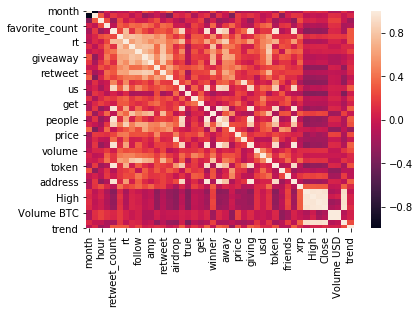

In [38]:
#View heatmap
sns.heatmap(df.corr())
plt.show()

## Modeling

In [39]:
# View columns
df.columns

Index(['month', 'day', 'hour', 'favorite_count', 'retweet_count', 'btc', 'rt',
       'bitcoin', 'follow', 'giveaway', 'amp', 'crypto', 'retweet', 'like',
       'airdrop', 'us', 'true', 'eth', 'get', 'wallet', 'winner', 'people',
       'away', 'tag', 'price', 'armtoken', 'giving', 'volume', 'usd', 'win',
       'token', 'join', 'friends', 'address', 'xrp', 'Date', 'Open', 'High',
       'Low', 'Close', 'Volume BTC', 'Volume USD', 'next_hour_close', 'trend'],
      dtype='object')

In [40]:
# Split into training and testing sets and standardize
scaler = StandardScaler()
X = df.drop(['month', 'day', 'hour', 'Date', 'next_hour_close', 'trend'], 1)
Y = df['trend']

'scaler.fit(X)'
'scaler.transform(X)'

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 75
The number of observations in test set is 19


### Logistic Regression

In [43]:
# Define logistic regression model
linmodel = LogisticRegression(solver='lbfgs', max_iter=1000)
cross_val_score(linmodel, X_train, y_train, cv=4)

array([0.63157895, 0.68421053, 0.52631579, 0.5       ])

In [44]:
# Fit on train data and predict test
linmodel.fit(X_train, y_train)
linpred = linmodel.predict(X_test)

In [45]:
# View accuracy
accuracy_score(y_test, linpred)

0.7894736842105263

In [46]:
# View confusion matrix
pd.crosstab(y_test, linpred, normalize='index')

col_0,0,1
trend,,
0,0.818182,0.181818
1,0.250000,0.750000


### Random Forest Model

In [47]:
# Define random forest model
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.75      , 0.6       , 0.8       , 0.66666667, 0.64285714])

In [48]:
# Fit on train data and predict test
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)

In [49]:
# View accuracy
accuracy_score(y_test, rfcpred)

0.631578947368421

In [50]:
# View confusion matrix
pd.crosstab(y_test, rfcpred, normalize = 'index')

col_0,0,1
trend,,
0,0.636364,0.363636
1,0.375000,0.625000


In [51]:
# Use random forest to view feature importance
pd.DataFrame(rfc.feature_importances_,
            index = X_train.columns,
            columns=['importance']).sort_values('importance', ascending=False)

,importance
token,0.098554
giving,0.086525
usd,0.062068
join,0.056733
eth,0.050136
armtoken,0.044478
us,0.043632
true,0.041530
giveaway,0.039217
bitcoin,0.039169


### K-Nearest Neighbors Model

In [52]:
# Define nearest neighbors model
knn = neighbors.KNeighborsClassifier()
cross_val_score(knn, X_train, y_train, cv=5)


array([0.5       , 0.66666667, 0.53333333, 0.53333333, 0.78571429])

In [53]:
# Fit on train data and predict test
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)

In [54]:
# View accuracy
accuracy_score(y_test, knnpred)

0.6842105263157895

In [55]:
# View confusion matrix
pd.crosstab(y_test, knnpred, normalize = 'index')

col_0,0,1
trend,,
0,0.727273,0.272727
1,0.375000,0.625000


What we're seeing here with a blank run of these algorithms is that the logistic regression model seems to be superior to both the random forest and nearest neighbor models.  Because of the high dimensionality of the data I'm going to eliminat the nearest neighbor model as a viable option and continue with the logistic regression model and the random forest model.  Using a grid search we'll tune both models and see which performs better.

### Tune logistic regression model

In [56]:
linmodel2 = LogisticRegression(max_iter=1000)

# Create a dictionary of hyperparameters to search
grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [100, 10, 1.0]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    linmodel2.set_params(**g)  # ** is "unpacking" the dictionary
    linmodel2.fit(X_train, y_train)
    test_scores.append(linmodel2.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.8421052631578947 {'solver': 'liblinear', 'C': 100}


In [57]:
# Define and predict tuned model
linmodel2 = LogisticRegression(solver='liblinear', max_iter=1000, C=100)
linmodel2.fit(X_train, y_train)
linpred2 = linmodel2.predict(X_test)

In [58]:
# View accuracy
accuracy_score(y_test, linpred2)

0.8421052631578947

In [59]:
# View confusion matrix
pd.crosstab(y_test, linpred2, normalize = 'index')

col_0,0,1
trend,,
0,0.818182,0.181818
1,0.125000,0.875000


### Tune random forest model

In [60]:
rfc2 = ensemble.RandomForestClassifier()

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 6, None], 'max_features': [4, 6, 8, 'auto'], 'min_samples_leaf': [2, 4, 6, 8]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfc2.set_params(**g)  # ** is "unpacking" the dictionary
    rfc2.fit(X_train, y_train)
    test_scores.append(rfc2.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.7368421052631579 {'n_estimators': 50, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': 3}


In [61]:
# Define and predict tuned model
rfc2 = ensemble.RandomForestClassifier(n_estimators = 100, min_samples_leaf = 4, max_features = 4, max_depth = None)
rfc2.fit(X_train, y_train)
rfcpred2 = rfc2.predict(X_test)

In [62]:
# View accuracy
accuracy_score(y_test, rfcpred2)

0.6842105263157895

In [63]:
# View confusion matrix
pd.crosstab(y_test, rfcpred2, normalize = 'index')

col_0,0,1
trend,,
0,0.727273,0.272727
1,0.375000,0.625000


## Clustering Visual
Due to the nature of the data let's see if an unsupervised clustering model is able to cluster in the desired trend based on similarities in the data.

In [76]:
from sklearn.cluster import KMeans

# Define, fit, and predict k_means model
k_means = KMeans(n_clusters=2, random_state=123)
k_means.fit(X_train)
k_pred = k_means.predict(X_test)

In [77]:
sympred2 = []
for n in k_pred:
    if n == 0:
        sympred2.append('-')
    else:
        sympred2.append('+')

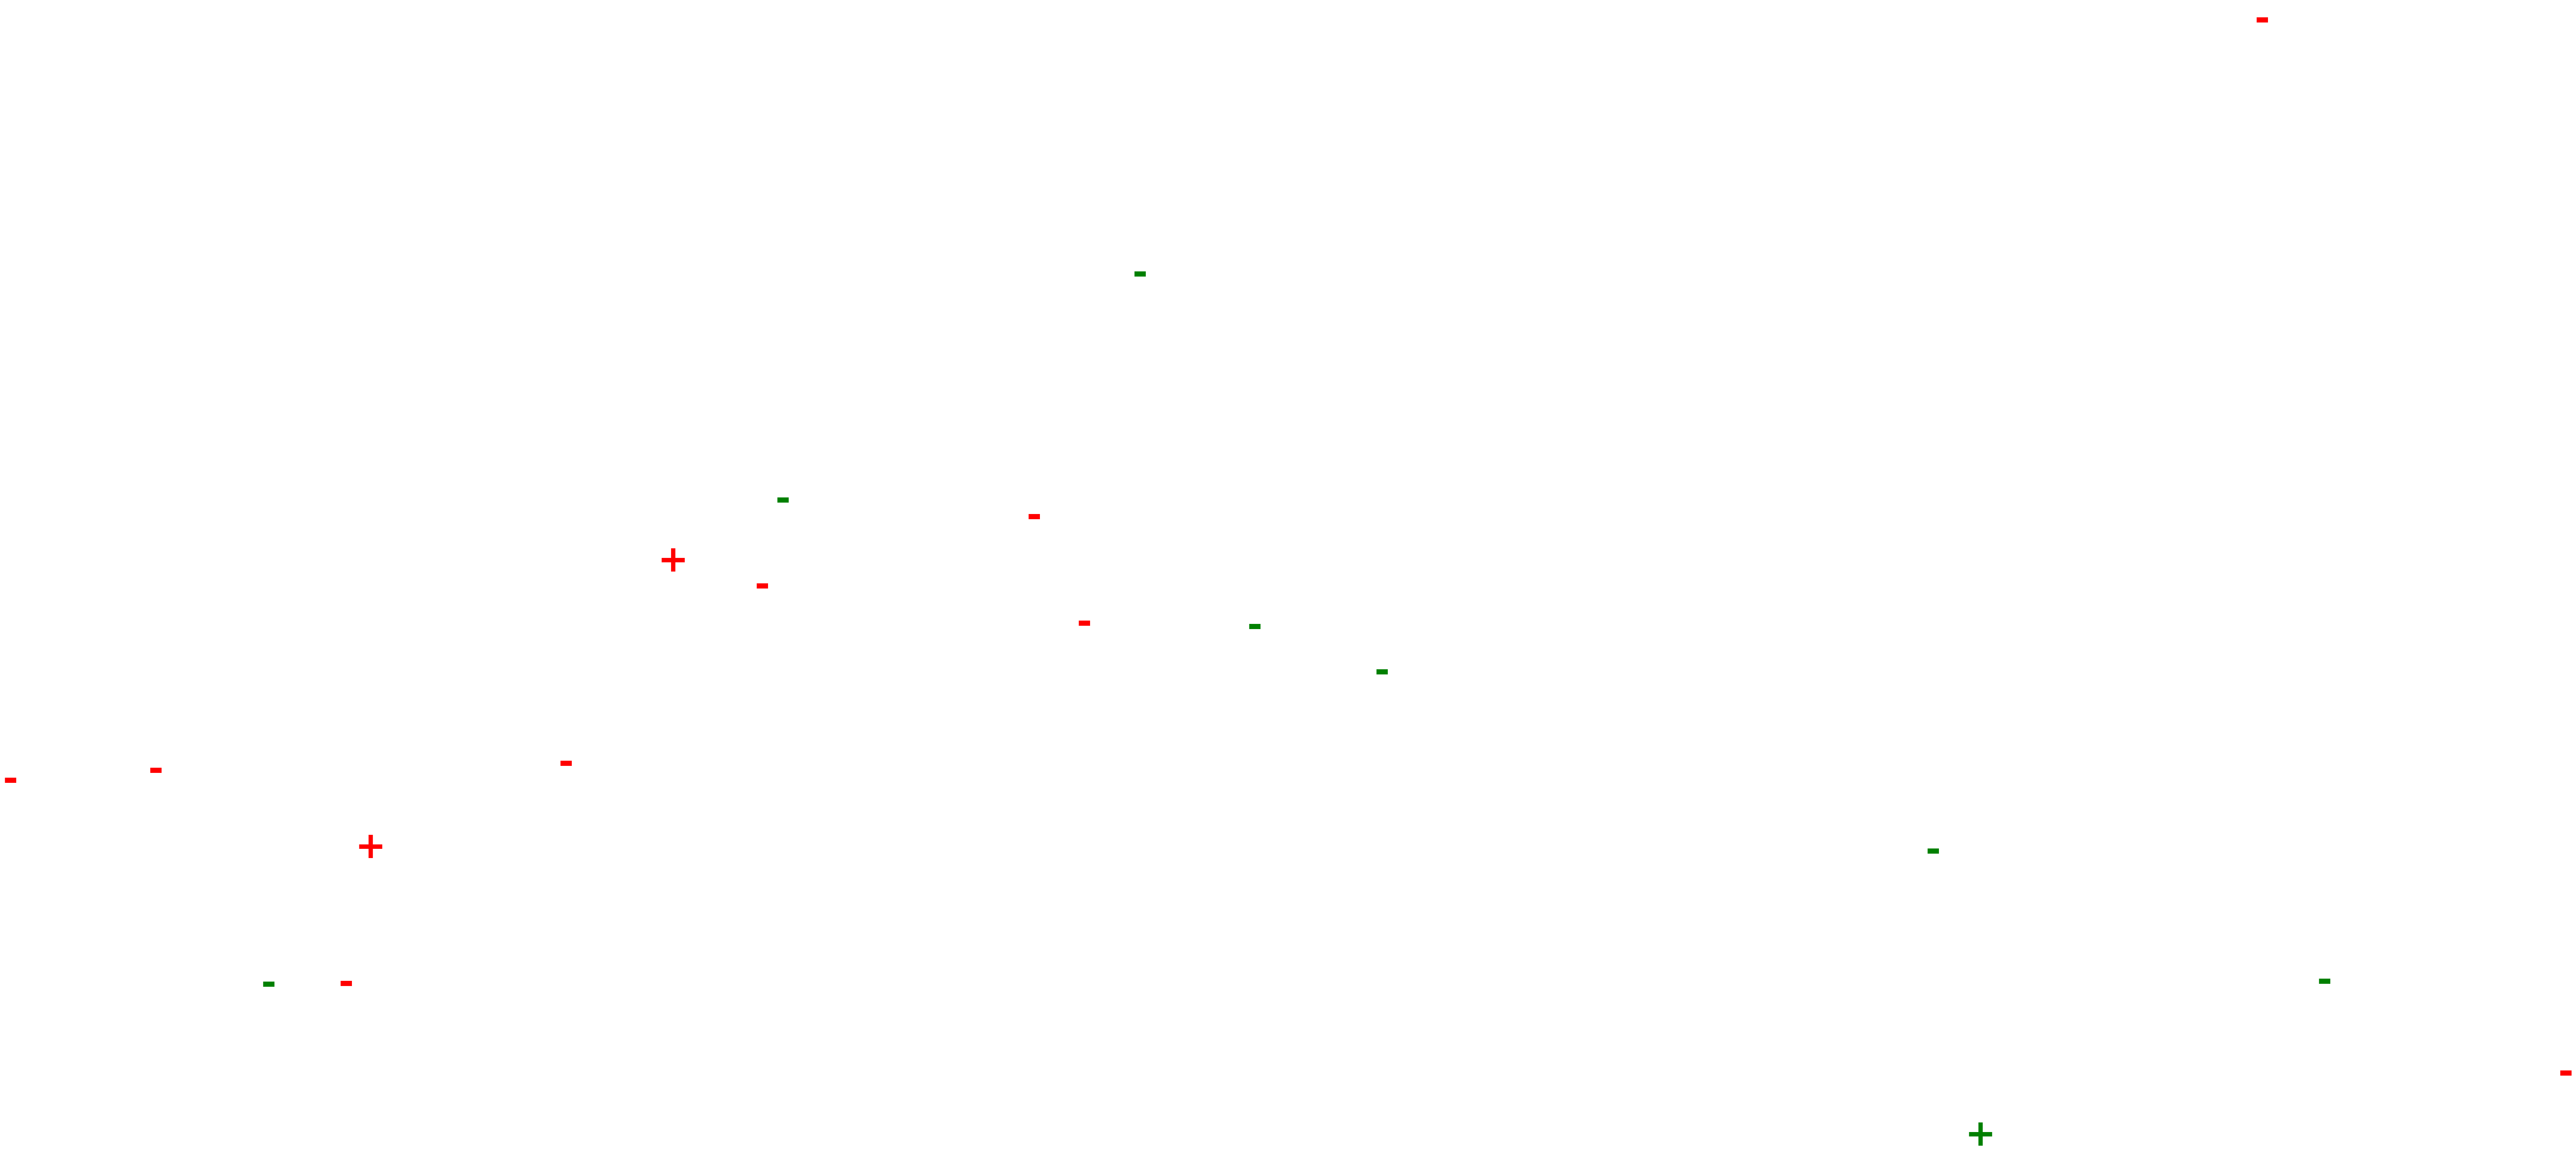

In [78]:
plt.figure(figsize=(10,5))
colours = 'rgb'
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str(sympred2[i]),
             color=colours[y_test.values[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [79]:
# View accuracy
accuracy_score(y_test, k_pred)

0.5263157894736842

In [80]:
# View confusion matrix
pd.crosstab(y_test, k_pred, normalize = 'index')

col_0,0,1
trend,,
0,0.818182,0.181818
1,0.875000,0.125000


Because a clustering algorithm cannot label based on the criteria, let's flip the predictions and look at the outcome too.

In [87]:
k_predflip = []
for n in k_pred:
    if n == 0:
        k_predflip.append(1)
    else:
        k_predflip.append(0)

In [89]:
# View accuracy
accuracy_score(y_test, k_predflip)

0.47368421052631576

We can see that in both cases the clustering algorithm performs poorly.

## Results and Visualization

In [70]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_test)

# We just want the first two principal components for visualization
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(X_std)

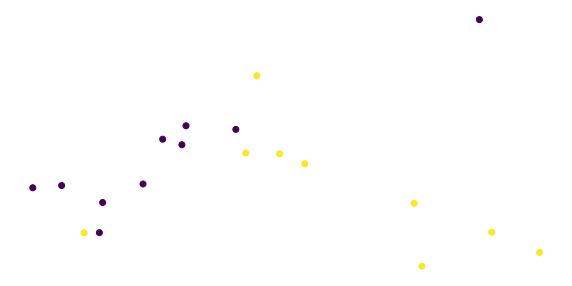

In [71]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=linpred2)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [72]:
sympred = []
for n in linpred2:
    if n == 0:
        sympred.append('-')
    else:
        sympred.append('+')

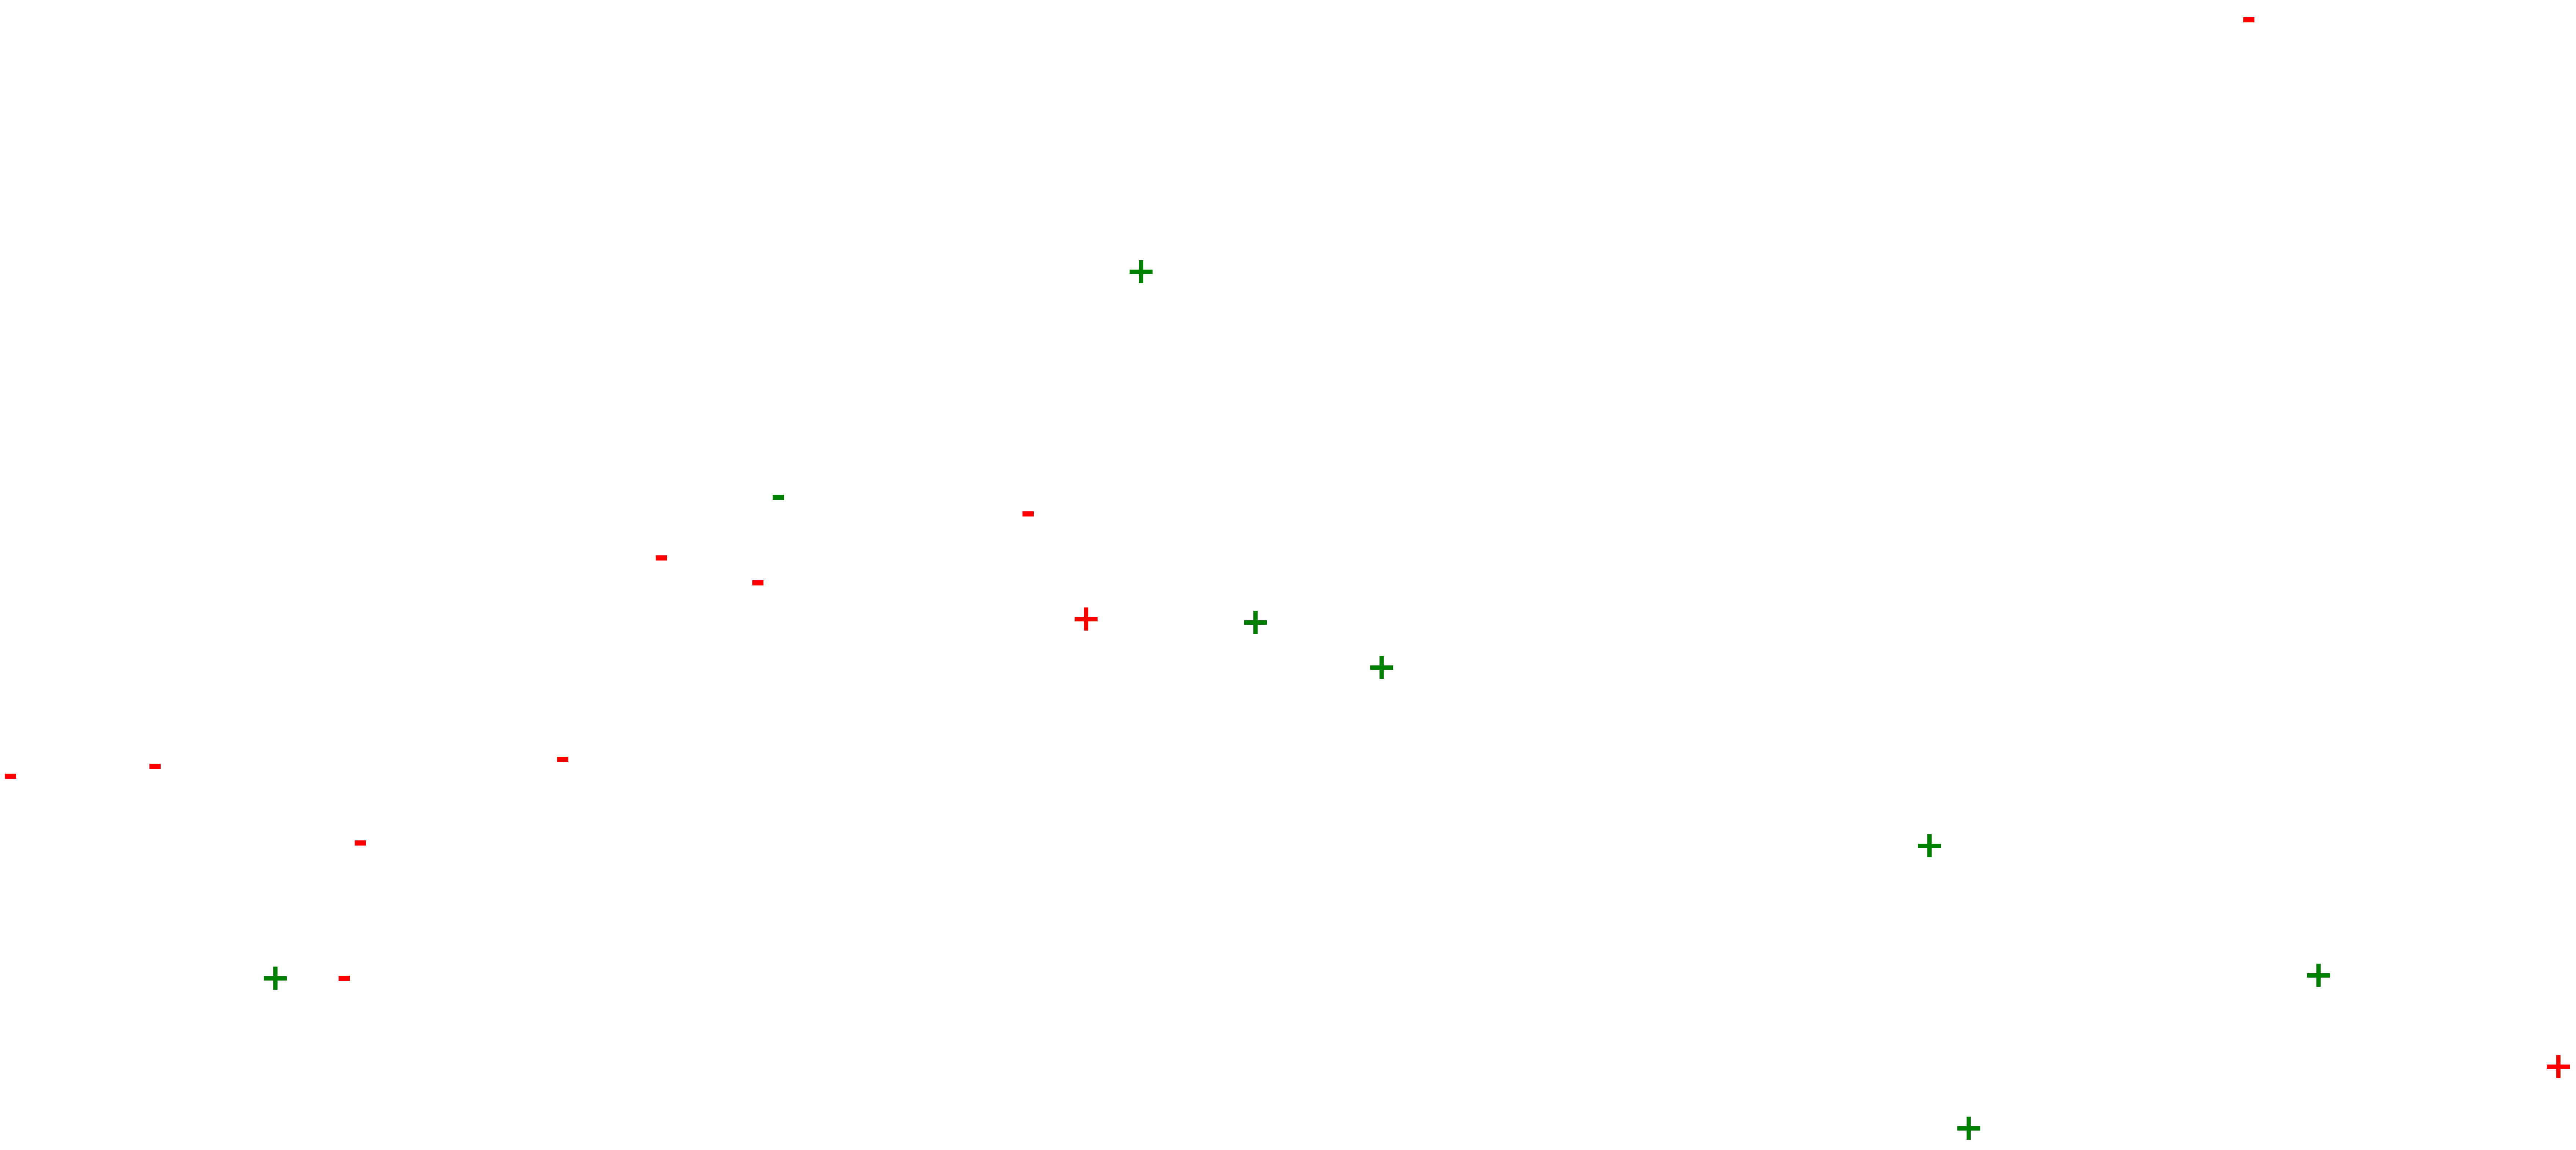

In [74]:
plt.figure(figsize=(10,5))
colours = 'rgb'
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str(sympred[i]),
             color=colours[y_test.values[i]],
             fontdict={'weight': 'bold', 'size': 100}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [75]:
pd.crosstab(y_test, linpred2, normalize = 'index')

col_0,0,1
trend,,
0,0.818182,0.181818
1,0.125000,0.875000


In this model 0 is defined as a downward trend and 1 is defined as an upward trend.  For our purposes what we'd like to minimize is the false positive predictions of the model.  If the model predicts a future upward trend and we purchase with the intent to sell later and it is actually a downward trend then we lose the price difference.  In that case as well as in the overall case the logistic regression model has proven superior over the random forest model.

Because of the limited scope of the API data collection the model was trained with limited data.  My next steps for this project would be to continue with the collection of twitter data over a several month period to get a larger distribution of trending data and rerun the model.  As we continue with the collection of twitter data the model will improve and I believe that with more data eventually the random forest model will perform better than the logistic regression model.

After having a model trained with more data I'd continue with the product by implementing a streaming feature to allow prediction in real-time.